In [72]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, roc_auc_score, roc_curve, precision_recall_curve, f1_score, fbeta_score
from sklearn.metrics import log_loss
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV


# preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

In [2]:
sepsis_df = pd.read_csv('sepsis_df.csv')

# create X and y for model
X = sepsis_df.drop(columns=['isSepsis'])
y = sepsis_df.isSepsis

In [57]:
# splitting into train, val, test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=248)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=248)

In [4]:
# very imbalanced dataset, needs resampling!
from collections import Counter
Counter(y_train)

Counter({0: 10344, 1: 292})

In [58]:
# resampling using random oversampling
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=0)

X_train, y_train = ros.fit_resample(X_train,y_train)

In [59]:
Counter(y_train)

Counter({0: 10344, 1: 10344})

In [7]:
from sklearn.metrics import make_scorer
# creating a new scoring metric that uses beta = 2
f_beta_2 = make_scorer(fbeta_score, beta=2)

In [65]:
def scores(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    fbeta = fbeta_score(y_true, y_pred, beta=2)

    print(f'Accuracy score: {accuracy}')
    print(f'Precision score: {precision}')
    print(f'Recall: {recall}')
    print(f'F1: {f1}')
    print(f'F-beta (beta=2): {fbeta}')

In [60]:
def make_confusion_matrix(model, threshold=0.5):
    # Predict class 1 if probability of being in class 1 is greater than threshold
    # (model.predict(X_test) does this automatically with a threshold of 0.5)
    y_predict = (model.predict_proba(X_val)[:, 1] >= threshold)
    sepsis_confusion = confusion_matrix(y_val, y_predict)
    plt.figure(dpi=80)
    sns.heatmap(sepsis_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='d',
           xticklabels=['No Sepsis', 'Sepsis'],
           yticklabels=['No Sepsis', 'Sepsis']);
    plt.xlabel('prediction')
    plt.ylabel('actual')

In [263]:
rf = RandomForestClassifier(n_estimators=500)
rf.fit(X_train, y_train)

rf_train_pred = rf.predict(X_train)
rf_val_pred = rf.predict(X_val)

In [264]:
scores(y_val, rf_val_pred)

Accuracy score: 0.9793233082706767
Precision score: 0.6956521739130435
Recall: 0.25
F1: 0.367816091954023
F-beta (beta=2): 0.2867383512544803


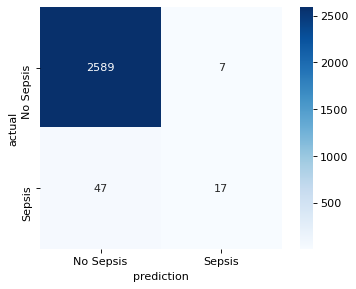

In [19]:
make_confusion_matrix(rf)

In [38]:
from sklearn.metrics import make_scorer
# creating a new scoring metric that uses beta = 2
f_beta_2 = make_scorer(fbeta_score, beta=2)

In [37]:
n_estimators = [x for x in range(50, 201, 10)]
bootstrap = [True, False]
max_depth = [x for x in range(1,11,1)]
max_depth.append(None)

In [35]:
n_estimators

[50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200]

In [44]:
random_grid = {'n_estimators':n_estimators, 
              'max_depth':max_depth,
              'bootstrap':bootstrap}

rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, 
                              n_iter = 60, cv = 5, verbose=2, n_jobs=-1, scoring=f_beta_2,
                              error_score='raise')

In [45]:
rf_random.fit(X_train, y_train)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


RandomizedSearchCV(cv=5, error_score='raise',
                   estimator=RandomForestClassifier(), n_iter=60, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                      10, None],
                                        'n_estimators': [50, 60, 70, 80, 90,
                                                         100, 110, 120, 130,
                                                         140, 150, 160, 170,
                                                         180, 190, 200]},
                   scoring=make_scorer(fbeta_score, beta=2), verbose=2)

In [46]:
rf_random.best_params_

{'n_estimators': 200, 'max_depth': None, 'bootstrap': False}

In [ ]:
scores()

In [270]:
from sklearn.metrics import classification_report

In [82]:
feature_importance_df = pd.DataFrame({'importance':rf.feature_importances_}, index=X_val.columns).sort_values(by='importance', ascending=False).reset_index().rename(columns={'index':'features'})

In [83]:
feature_importance_df

,features,importance
0,ICULOS,0.258271
1,HospAdmTime,0.077168
2,HR,0.063163
3,BUN,0.057867
4,WBC,0.053017
5,Hct,0.046146
6,Platelets,0.044700
7,Creatinine,0.043733
8,Hgb,0.043057
9,Age,0.040639


Text(0.5, 1.0, 'Feature Importances')

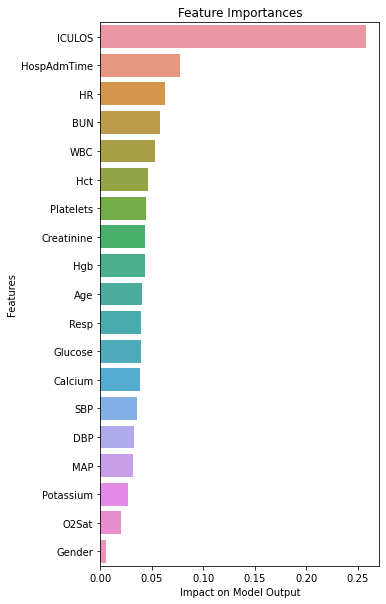

In [85]:
from matplotlib import pyplot
fig,ax = pyplot.subplots(figsize=(5,10))

sns.barplot(y=feature_importance_df['features'], x=feature_importance_df['importance'])
plt.xlabel('Impact on Model Output')
plt.ylabel('Features')
plt.title('Feature Importances')


In [132]:
X_rand_sample = X.sample(n=10)

In [133]:
type(X_rand_sample)

pandas.core.frame.DataFrame

In [112]:
list(X_rand_sample.index)

[3973, 12520, 7617, 11234, 3851, 1217, 4817, 7975, 10544, 1709]

In [120]:
[sepsis_df['isSepsis'][x] for x in list(X_rand_sample.index)]

[0, 0, 0, 0, 1, 0, 0, 0, 0, 1]

In [119]:
actuals_df = pd.DataFrame([sepsis_df['isSepsis'][x] for x in list(X_rand_sample.index)])
actuals_df.columns = ['Actuals']
actuals_df

,Actuals
0,0
1,0
2,0
3,0
4,1
5,0
6,0
7,0
8,0
9,1


In [219]:
rand_sample = X.sample(n=10)

preds = list(rf.predict(rand_sample))

indexes = list(rand_sample.index)

actuals = [sepsis_df['isSepsis'][x] for x in list(rand_sample.index)]

In [220]:
comparison_df = pd.DataFrame(
    {'index':indexes,
     'predicted': preds,
     'actual': actuals,
    })
comparison_df = comparison_df.set_index('index')

In [222]:
comparison_df

,predicted,actual
index,,
10293,0,0
1326,0,0
7302,0,0
472,0,0
4581,0,0
8883,0,0
9191,0,0
6064,0,0
2026,0,1


In [223]:
pd.concat([rand_sample, comparison_df],axis=1)

,HR,O2Sat,SBP,MAP,DBP,Resp,BUN,Calcium,Creatinine,Glucose,...,Hct,Hgb,WBC,Platelets,Age,Gender,HospAdmTime,ICULOS,predicted,actual
10293,92.0,100.0,112.0,83.0,70.0,20.0,17.0,8.7,0.88,104.0,...,28.7,9.4,7.1,100.0,46.00,1,-125.55,9,0,0
1326,46.0,99.0,144.0,83.0,65.0,14.0,13.0,8.2,0.80,143.0,...,32.2,11.4,7.2,253.0,65.26,0,-74.29,4,0,0
7302,98.0,99.0,146.0,110.0,87.0,18.0,18.0,8.5,1.63,142.5,...,43.4,14.6,8.8,179.0,59.00,1,-95.12,8,0,0
472,58.0,98.0,142.0,89.0,62.0,16.0,21.0,8.8,0.90,105.0,...,34.5,11.6,30.6,269.0,64.85,0,-51.94,7,0,0
4581,123.0,99.0,83.0,49.0,37.0,29.0,29.0,9.2,6.30,128.0,...,34.7,11.5,28.8,562.0,42.83,0,-2.00,4,0,0
8883,92.0,98.0,166.0,104.0,72.0,18.0,23.0,8.5,0.87,144.5,...,19.2,6.5,0.5,17.0,76.00,0,-6.26,5,0,0
9191,64.0,100.0,91.0,66.0,59.0,12.0,23.0,8.9,0.97,69.0,...,25.5,7.1,9.9,278.0,53.00,0,-2.49,19,0,0
6064,98.0,100.0,151.5,96.5,64.0,13.0,10.0,8.1,0.59,105.5,...,28.0,9.2,10.1,179.0,78.00,0,-241.42,15,0,0
2026,67.0,100.0,114.0,68.0,43.0,12.0,69.0,8.7,3.20,115.0,...,34.8,10.6,17.5,289.0,83.95,1,-2.74,8,0,1
12633,82.0,95.0,161.0,106.0,80.0,18.0,15.0,7.8,0.92,86.0,...,36.7,12.1,3.2,54.0,59.00,1,-10.94,3,0,0


In [249]:
def model_results(X):
    rand_sample = X.sample(n=10)

    preds = list(rf.predict(rand_sample))

    indexes = list(rand_sample.index)

    actuals = [sepsis_df['isSepsis'][x] for x in list(rand_sample.index)]
    
    comparison_df = pd.DataFrame(
    {'index':indexes,
     'predicted': preds,
     'actual': actuals,
    })
    
    comparison_df = comparison_df.set_index('index')
    result_df = pd.concat([rand_sample, comparison_df],axis=1)
    
    return result_df

In [262]:
model_results(X)

,HR,O2Sat,SBP,MAP,DBP,Resp,BUN,Calcium,Creatinine,Glucose,...,Hct,Hgb,WBC,Platelets,Age,Gender,HospAdmTime,ICULOS,predicted,actual
15696,98.0,99.0,152.00,137.00,95.0,18.0,35.0,4.77,1.20,135.0,...,32.0,10.5,22.1,86.0,52.00,1,-72.36,13,0,0
14403,78.0,99.0,147.00,88.00,60.0,16.0,15.0,8.60,1.06,137.0,...,29.0,9.4,9.1,50.0,77.00,1,-24.80,16,0,0
15340,91.0,99.0,102.00,72.00,61.0,18.0,11.0,7.40,0.88,153.0,...,30.5,10.3,12.2,77.0,67.00,1,-29.73,7,0,0
2741,82.0,99.0,108.00,82.00,68.0,20.0,9.0,8.40,0.40,177.0,...,35.2,11.9,27.2,357.0,75.89,0,-0.02,11,0,0
5145,103.5,93.0,220.75,115.67,98.0,12.0,27.0,6.70,1.10,129.0,...,41.9,15.0,8.2,85.0,77.39,1,-0.02,13,0,0
16071,81.0,100.0,131.00,75.00,54.0,21.0,25.0,8.70,1.47,139.0,...,23.7,7.9,17.5,96.0,76.00,0,-72.79,11,0,0
2852,82.0,99.0,110.00,75.00,60.0,15.0,13.0,9.60,1.60,57.0,...,24.4,8.1,6.3,44.0,51.29,1,-179.18,20,1,1
5046,103.0,100.0,106.00,73.00,59.0,21.0,24.0,8.50,0.90,185.0,...,27.5,10.9,7.9,118.0,62.52,1,-6.88,9,0,0
11302,87.0,99.0,86.00,64.00,57.0,18.0,13.0,8.40,0.86,98.0,...,37.3,12.3,9.3,287.0,42.00,1,-20.23,41,0,0
7126,114.0,100.0,145.00,137.00,129.0,16.0,12.0,8.60,0.66,133.0,...,36.0,12.2,16.5,143.0,50.00,0,-391.98,8,0,0


In [251]:
sepsis_df['isSepsis'][14868]

0

In [ ]:
test = pd.DataFrame()